In [1]:
%matplotlib inline

d'après https://dedalus-project.readthedocs.io/en/latest/notebooks/KelvinHelmholtzInstability.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from IPython import display

from dedalus import public as de
from dedalus.extras import flow_tools

import logging
logger = logging.getLogger(__name__)

## problem domain
on specifie le domaine, on doit définir les bases x et y.
Chebychev polynomes, boudary conditions dans la direction y

In [3]:
#Aspect ratio 2
Lx, Ly = (2., 1.)
nx, ny = (192, 96)

# Create bases and domain
x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Chebyshev('y',ny, interval=(-Ly/2, Ly/2), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

In [4]:
Reynolds = 1e4
Schmidt = 1.

problem = de.IVP(domain, variables=['p','u','v','uy','vy','S','Sy'])
problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt
problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) = - u*dx(v) - v*vy")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(S) - 1/(Re*Sc)*(dx(dx(S)) + dy(Sy)) = - u*dx(S) - v*Sy")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("Sy - dy(S) = 0")

In [5]:
problem.add_bc("left(u) = 0.5")
problem.add_bc("right(u) = -0.5")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("left(p) = 0", condition="(nx == 0)")
problem.add_bc("left(S) = 0")
problem.add_bc("right(S) = 1")

In [6]:
ts = de.timesteppers.RK443

In [7]:
solver =  problem.build_solver(ts)

2020-11-20 15:15:41,028 pencil 0/1 INFO :: Building pencil matrix 1/96 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 2.8e+01/s
2020-11-20 15:15:41,242 pencil 0/1 INFO :: Building pencil matrix 10/96 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 4.0e+01/s
2020-11-20 15:15:41,450 pencil 0/1 INFO :: Building pencil matrix 20/96 (~21%) Elapsed: 0s, Remaining: 2s, Rate: 4.4e+01/s
2020-11-20 15:15:41,736 pencil 0/1 INFO :: Building pencil matrix 30/96 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 4.0e+01/s
2020-11-20 15:15:42,025 pencil 0/1 INFO :: Building pencil matrix 40/96 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.9e+01/s
2020-11-20 15:15:42,390 pencil 0/1 INFO :: Building pencil matrix 50/96 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s
2020-11-20 15:15:42,612 pencil 0/1 INFO :: Building pencil matrix 60/96 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 3.7e+01/s
2020-11-20 15:15:42,999 pencil 0/1 INFO :: Building pencil matrix 70/96 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 3.5e+01/s
2020-11-20 15:15:4

In [8]:
x = domain.grid(0)
y = domain.grid(1)
u = solver.state['u']
uy = solver.state['uy']
v = solver.state['v']
vy = solver.state['vy']
S = solver.state['S']
Sy = solver.state['Sy']

a = 0.05
sigma = 0.2
flow = -1.5
amp = -0.2
u['g'] = flow*np.tanh(y/a)
v['g'] = amp*np.sin(2.0*np.pi*x/Lx)*np.exp(-(y*y)/(sigma*sigma))
S['g'] = 0.5*(1+np.tanh(y/a))
u.differentiate('y',out=uy)
v.differentiate('y',out=vy)
S.differentiate('y',out=Sy)

<Field 139666579496144>

In [9]:
solver.stop_sim_time = 2.01
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

initial_dt = 0.2*Lx/nx
cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
cfl.add_velocities(('u','v'))

In [10]:
analysis = solver.evaluator.add_file_handler('analysis_tasks', sim_dt=0.1, max_writes=50)
analysis.add_task('S')
analysis.add_task('u')
solver.evaluator.vars['Lx'] = Lx
analysis.add_task("integ(S,'x')/Lx", name='S profile')

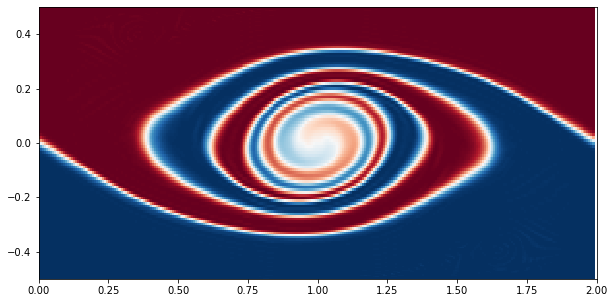

2020-11-20 15:24:08,514 __main__ 0/1 INFO :: Iteration: 870, Time: 1.993653e+00, dt: 2.032287e-03
2020-11-20 15:24:13,535 solvers 0/1 INFO :: Simulation stop time reached.


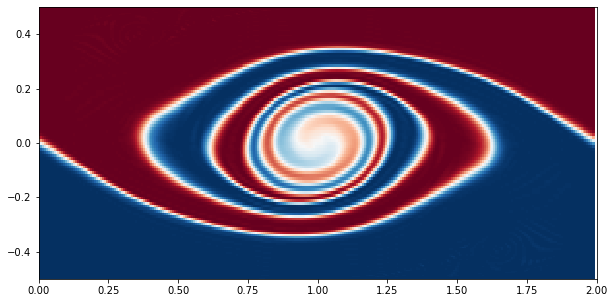

In [11]:
# Make plot of scalar field
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, S['g'].T, cmap='RdBu_r');
axis.set_xlim([0,2.])
axis.set_ylim([-0.5,0.5])

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    dt = cfl.compute_dt()
    solver.step(dt)
    if solver.iteration % 10 == 0:
        # Update plot of scalar field
        p.set_array(np.ravel(S['g'][:-1,:-1].T))
        display.clear_output()
        display.display(plt.gcf())
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

end_time = time.time()

p.set_array(np.ravel(S['g'][:-1,:-1].T))

In [12]:
# Read in the data
f = h5py.File('analysis_tasks/analysis_tasks_s1/analysis_tasks_s1_p0.h5','r')
y = f['/scales/y/1.0'][:]
t = f['scales']['sim_time'][:]
S_ave = f['tasks']['S profile'][:]
f.close()

S_ave = S_ave[:,0,:] # remove length-one x dimension

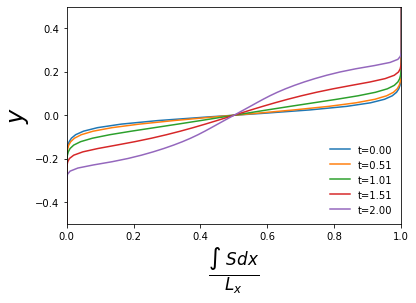

In [13]:
for i in range(0,21,5):
  plt.plot(S_ave[i,:],y,label='t=%4.2f' %t[i])

plt.ylim([-0.5,0.5])
plt.xlim([0,1])
plt.xlabel(r'$\frac{\int \ S dx}{L_x}$',fontsize=24)
plt.ylabel(r'$y$',fontsize=24)
plt.legend(loc='lower right').draw_frame(False)